# Technical notebook - Ecstasy usage prediction

**What is Ecstasy?**
https://adf.org.au/drug-facts/mdma/

Ecstasy is the common name of MDMA. However, some pills sold as ecstasy may only have a small amount of MDMA or none at all. Other drugs and ‘fillers’ are often used instead. This makes it hard to know what reactions to expect after taking MDMA or if negative side effects will be experienced.

Methylenedioxymethamphetamine (MDMA) is an an empathogen, which means it increases an individual’s feeling of empathy and compassion towards others.

**Other names**
Ecstasy, Eckies, E, XTC, pills, pingers, bikkies, flippers, molly.1

**How is MDMA used?**
MDMA usually comes in a tablet form and is swallowed. The pills come in different colours and sizes and are often imprinted with a picture or symbol.1 It can also come as capsules, powder or crystal.

**Effects of MDMA**

- euphoria
- feeling energetic and confident
- large pupils
- jaw clenching and teeth grinding
- heightened senses (sight, hearing and touch)
- excessive sweating and skin tingles
- muscle aches and pains
- reduced appetite
- fast heartbeat
- increased blood pressure
- dehydration
- heat stroke
- drinking extreme amounts of water (can cause death)

**Long term effects**

- colds or flu
- depression
- needing to use more to get the same effect
- dependence on MDMA
- memory and concentration problems
- financial, work and social problems

**Withdrawal**
Giving up MDMA after using it for a long time is challenging because the body has to get used to functioning without it. Withdrawal symptoms should settle down after a week and will mostly disappear after a month. 

## Research question: is it possible to predict from demographic and personality features that somebody becomes an ecstasy user?

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

#plotting the decision trees
from sklearn import tree

## 1. Preprocessing

### Upload the datafile

In [2]:
data = pd.read_csv('ecstasy.csv', index_col=0)

In [99]:
# data.head()

In [100]:
# data.columns

### Feature and target variables

In [6]:
y = data.User
X = data.drop(['User'], axis=1)

In [7]:
X.columns

Index(['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion', 'Openness',
       'Agreeableness', 'Conscientiousness', 'Impulsiveness',
       'Sensation-seeking'],
      dtype='object')

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=220, stratify=y)

In [9]:
y_train.mean()

0.39854111405835546

### Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = X_train
scaler.fit(X_train_scaled[['Age', 'Education']])
X_train_scaled[['Age', 'Education']] = scaler.transform(X_train_scaled[['Age', 'Education']])

In [11]:
X_train_scaled.head(2)

,Age,Gender,Education,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsiveness,Sensation-seeking
116,0.499858,1,0.009691,0.62967,-0.57545,0.14143,-1.77200,-0.40581,0.52975,-0.21575
965,-1.051141,0,-0.552366,-0.24649,0.16767,1.88511,1.45039,-0.40581,1.29221,1.22470


In [12]:
X_test_scaled = X_test
X_test_scaled[['Age', 'Education']] = scaler.transform(X_test_scaled[['Age', 'Education']])

In [97]:
# X_test_scaled.head(2)

In [14]:
scaler.mean_

array([1.35543767, 4.98275862])

In [15]:
scaler.var_

array([1.66278873, 3.16548523])

## 2. Modeling

We were comparing the following models:
    - Logistic regression
    - Decesion tree
    - Random forest
    - Gradient boosting
    - XGBoosting
    - K Nearest Neighbors
    - Support Vector Machine

To select the best performing parameters we were applying gridsearch.

Every model is tested on the test set. Big difference between 'Best score' and 'Test score' implies overfitting of the model.


## 2.1. Logistic regression

In [16]:
params = {'C': np.logspace(-2, 4, 7),
          'penalty' : ['l1','l2']}

log_grid = GridSearchCV(estimator=LogisticRegression(random_state=123),
                          param_grid=params,
                          scoring='accuracy',
                          cv=5, verbose=1, n_jobs=-1)

log_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [17]:
print(f'Best score: {log_grid.best_score_:.3f}')
print('Best parameters:\n\t',log_grid.best_params_)
print(f'Test score: {log_grid.best_estimator_.score(X_test_scaled, y_test):.3f}')

Best score: 0.749
Best parameters:
	 {'C': 0.01, 'penalty': 'l2'}
Test score: 0.732


In [18]:
coefs = pd.DataFrame(zip(X.columns, log_grid.best_estimator_.coef_[0]), columns=['Feature', 'Coef'])
coefs.sort_values(by='Coef')

,Feature,Coef
0,Age,-0.505322
7,Conscientiousness,-0.182681
2,Education,-0.168978
6,Agreeableness,-0.082988
3,Neuroticism,0.034934
4,Extraversion,0.047621
8,Impulsiveness,0.075002
1,Gender,0.106554
5,Openness,0.333606
9,Sensation-seeking,0.388443


## 2.2. Decision tree

In [19]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5, 6, 7],
          'min_samples_split': [20, 40, 60, 80],
          'min_impurity_split': [0.03, 0.05, 0.1, 0.2]}

tree_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=111),
                         param_grid=params,
                         scoring='accuracy',
                         cv=5, verbose=1, n_jobs=-1)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    3.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7],
                        

In [20]:
print(f'Best score: {tree_grid.best_score_:.3f}')
print('Best parameters:\n\t', tree_grid.best_params_)
print(f'Test score: {tree_grid.best_estimator_.score(X_test, y_test):.3f}')

Best score: 0.735
Best parameters:
	 {'criterion': 'gini', 'max_depth': 4, 'min_impurity_split': 0.2, 'min_samples_split': 40}
Test score: 0.727


In [21]:
feat_imp = pd.DataFrame(zip(X.columns, tree_grid.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp

,Feature,Importance
0,Age,0.302462
1,Gender,0.032392
2,Education,0.018051
3,Neuroticism,0.011372
4,Extraversion,0.000000
5,Openness,0.082476
6,Agreeableness,0.011631
7,Conscientiousness,0.062216
8,Impulsiveness,0.000000
9,Sensation-seeking,0.479400


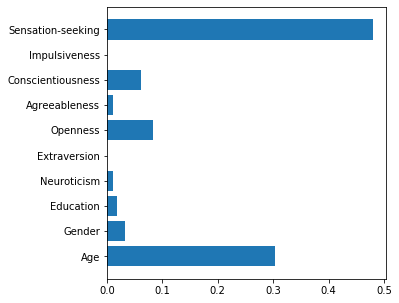

In [22]:
plt.figure(figsize=(5,5))
plt.barh(feat_imp.Feature, feat_imp.Importance);

## 2.3. Random Forest

In [23]:
params = {'n_estimators': [10, 100, 200, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth': [2, 4, 6, 8, 10],
          'max_features': [2, 4, 6, 8]}

rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=222),
                       param_grid=params,
                       scoring='accuracy',
                       cv=5, verbose=1, n_jobs=-1)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [25]:
print(f'Best score: {rf_grid.best_score_:.3f}')
print('Best parameters:\n\t',rf_grid.best_params_)
print(f'Test score: {rf_grid.best_estimator_.score(X_test, y_test):.3f}')

Best score: 0.747
Best parameters:
	 {'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'n_estimators': 200}
Test score: 0.721


In [26]:
feat_imp_rf = pd.DataFrame(zip(X.columns, rf_grid.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp_rf.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp_rf

,Feature,Importance
0,Age,0.206653
9,Sensation-seeking,0.187875
5,Openness,0.148012
7,Conscientiousness,0.095973
2,Education,0.073912
8,Impulsiveness,0.064825
4,Extraversion,0.060068
3,Neuroticism,0.059851
6,Agreeableness,0.055942
1,Gender,0.046888


## 2.4. Gradient Boosting

In [29]:
params = {"learning_rate": [0.1, 0.2, 0.4],
          'max_depth': [2, 3, 4, 5],
          'max_features': [2, 3, 4, 5],
          'n_estimators': [10, 50, 100, 200],
          }

g_boost = GridSearchCV(estimator=GradientBoostingClassifier(random_state=123),
                          param_grid=params,
                          scoring='accuracy',
                          cv=5, verbose=1, n_jobs=-1)

g_boost.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   59.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [30]:
print(f'Best score: {g_boost.best_score_:.3f}')
print('Best parameters:\n\t',g_boost.best_params_)
print(f'Test score: {g_boost.best_estimator_.score(X_test, y_test):.3f}')

Best score: 0.749
Best parameters:
	 {'learning_rate': 0.4, 'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
Test score: 0.714


In [31]:
feat_imp_gb = pd.DataFrame(zip(X.columns, g_boost.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp_gb.sort_values(by='Importance', ascending=False)

,Feature,Importance
9,Sensation-seeking,0.243655
0,Age,0.208606
5,Openness,0.155950
2,Education,0.090225
7,Conscientiousness,0.074847
3,Neuroticism,0.058696
4,Extraversion,0.046805
6,Agreeableness,0.044582
8,Impulsiveness,0.039006
1,Gender,0.037627


## 2.5. XGBoost

In [32]:
params = {"learning_rate": [0.1, 0.2],
          'max_depth': [2, 3, 4, 5],
          'min_child_weight': [0.1, 0.2, 0.3],
          'subsample': [0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 150, 200],
          }

xg_boost = GridSearchCV(estimator=xgb.XGBClassifier(random_state=234),
                          param_grid=params,
                          scoring='accuracy',
                          cv=5, verbose=1, n_jobs=-1)

xg_boost.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=234, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [2, 3, 4, 5],
                         'min_child_weight': [0.1

In [33]:
print(f'Best score: {xg_boost.best_score_:.3f}')
print('Best parameters:\n\t',xg_boost.best_params_)
print(f'Test score: {xg_boost.best_estimator_.score(X_test, y_test):.3f}')

Best score: 0.747
Best parameters:
	 {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 0.1, 'n_estimators': 50, 'subsample': 0.3}
Test score: 0.711


## 2.6. KNN 

In [36]:
params = {'n_neighbors': range(1, 30, 2)}


knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid=params,
                        scoring='accuracy',
                        cv=5, verbose=1, n_jobs=-1)

knn_grid.fit(X_train_scaled, y_train)

print(f'Best score: {knn_grid.best_score_:.3f}')
print('Best parameters:\n\t', knn_grid.best_params_)
print(f'Test score: {knn_grid.best_estimator_.score(X_test_scaled, y_test):.3f}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.737
Best parameters:
	 {'n_neighbors': 25}
Test score: 0.703


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished


## 2.7. Support Vector Machine

In [76]:
params = {'kernel': ['linear', 'poly', 'rbf'],
          'C': [0.1, 1, 10, 1000], #high C allows narrow mistakes
          'degree': [2, 3]}


svm_grid = GridSearchCV(estimator=svm.SVC(random_state=766),
                        param_grid=params,
                        scoring='accuracy',
                        cv=5, verbose=1, n_jobs=-1)

svm_grid.fit(X_train_scaled, y_train)

print(f'Best score: {svm_grid.best_score_:.3f}')
print('Best parameters:\n\t', svm_grid.best_params_)
print(f'Test score: {svm_grid.best_estimator_.score(X_test_scaled, y_test):.3f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


Best score: 0.755
Best parameters:
	 {'C': 1, 'degree': 2, 'kernel': 'linear'}
Test score: 0.727


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


## FINDINGS

## 3.1. ROC curves

We are using ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) to compare the performance of different models and select the most predictible one. The x axis of the ROC curve is the False Positive Rate (we want to minimize it), the y axis is the True Positive Rate (we want to maximize it). So, a model which follows the dotted black line is not better than a random guess, a model which lies is above it, and goes along the y axes (AUC = 1) are the perfect predictors. The area under the curve is the quantification of the ROC curves, and the higher is the number, the better predictor is the model. AUC = 1 is the perfect predictor.

In [93]:
def plot_roc(predicted, name):
    fpr, tpr, tresh = roc_curve(y_test, predicted)
    auc_score = round(roc_auc_score(y_test, predicted),2)
    plt.plot(fpr, tpr, label = f'{name}   (auc = {auc_score})')

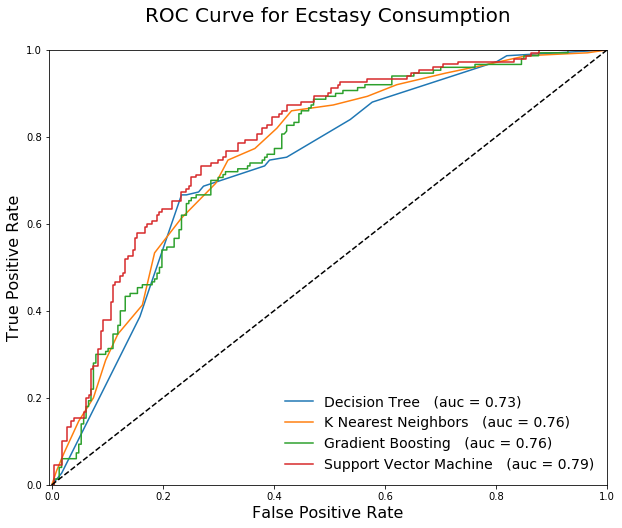

In [94]:
plt.figure(figsize=(10,8))

plot_roc(tree_grid.best_estimator_.predict_proba(X_test)[:,1], 'Decision Tree')
# plot_roc(rf_grid.best_estimator_.predict_proba(X_test)[:,1],'Random Forest')
# plot_roc(xg_boost.best_estimator_.predict_proba(X_test)[:,1], 'XGBoost')
plot_roc(knn_grid.best_estimator_.predict_proba(X_test_scaled)[:,1], 'K Nearest Neighbors')
plot_roc(g_boost.best_estimator_.predict_proba(X_test)[:,1], 'Gradient Boosting')
plot_roc(svm_grid.best_estimator_.decision_function(X_test_scaled), 'Support Vector Machine')
# plot_roc(log_grid.best_estimator_.decision_function(X_test_scaled), 'Logistic Regression')

plt.title('ROC Curve for Ecstasy Consumption\n', fontsize=20)
plt.plot((0,1), (0,1), ls='--', color='black')
plt.legend(loc = 'lower right', frameon=False, fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim(-0.005,1)
plt.ylim(0,1)
ax =  plt.gca()
plt.savefig('ROC_curve_ecstasy.png', bbox_inches='tight')

According to the ROC and AUC result, we were choosing SVM model as the best predictor for predicting that somebody becomes ecstasy user.

## 3.2 Interprete the result of the SVM model

In [95]:
feat_imp_svm = pd.DataFrame(zip(X.columns, svm_grid.best_estimator_.coef_[0]), 
                        columns=['Feature', 'Coef'])
feat_imp_svm['Abs_coef'] = feat_imp_svm.Coef.apply(lambda x: abs(x))
feat_imp_svm = feat_imp_svm.sort_values(by='Abs_coef')

In [96]:
feat_imp_svm

,Feature,Coef,Abs_coef
3,Neuroticism,0.013300,0.013300
8,Impulsiveness,-0.037726,0.037726
4,Extraversion,0.044689,0.044689
6,Agreeableness,-0.071096,0.071096
2,Education,-0.151085,0.151085
7,Conscientiousness,-0.200047,0.200047
5,Openness,0.367234,0.367234
9,Sensation-seeking,0.445001,0.445001
1,Gender,0.452999,0.452999
0,Age,-0.629330,0.629330


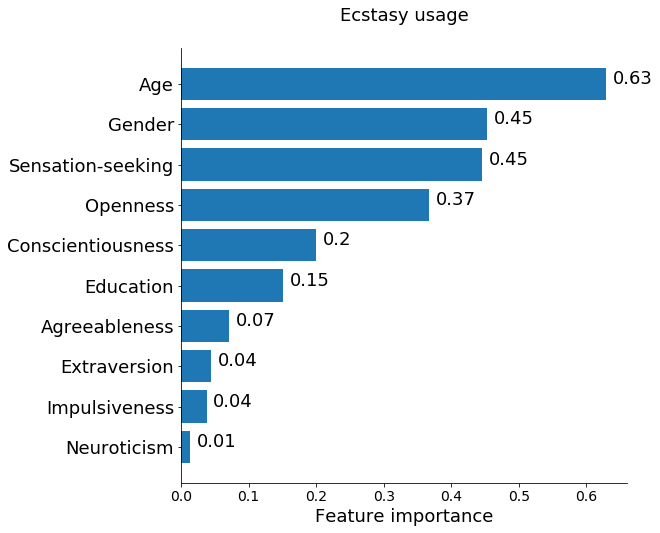

In [89]:
plt.figure(figsize=(8,8))
plt.barh(feat_imp_svm.Feature, feat_imp_svm.Abs_coef)
plt.title('Ecstasy usage\n', size=18)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.xlabel("Feature importance", size=18)

for i, v in enumerate(feat_imp_svm.Abs_coef):
    ax.text(v + 0.01, i, str(round(v,2)), color='black', fontsize=18)
    
plt.savefig('Feature_imp_ecstasy2.png', bbox_inches='tight')

In case of SVM model, if the kernel is linear, the feature importance is available from coefficients, since our variables are scaled. The absolute value of the coefficient can be interpreted as the featuer importance, the positive/negative value can be interpreted as their relation to becoming an ecstasy user. (For example: the higher is the openness, sensation score, it is more likely, however the older and more educated is less likely to become an ecsatsy user.)

## 3.3. Confusion Matrix

In [74]:
svm_cm = pd.DataFrame(confusion_matrix(y_test, svm_grid.best_estimator_.predict(X_test_scaled)),
                      index=['actual non-user', 'actual user'],
                      columns=['predicted non-user', 'predicted user'])
svm_cm = round(svm_cm/len(y_test),2)

In [75]:
svm_cm

,predicted non-user,predicted user
actual non-user,0.47,0.14
actual user,0.14,0.26


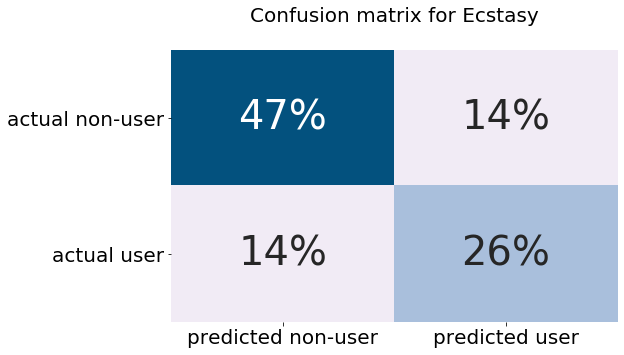

In [92]:
plt.figure(figsize=(8,5))
plt.title('Confusion matrix for Ecstasy\n', fontsize=20)
# sns.set(font_scale=1.4)  # for label size
sns.heatmap(svm_cm, cmap=sns.color_palette("PuBu", 10), annot=True,
            fmt='.0%', annot_kws={'size': 40}, cbar=False)
plt.yticks(rotation=0, fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('Conf_m_ecstasy.png', bbox_inches='tight')